# Evaluation of Salinity Below 5 m

## Salinity 5 m and deeper  
Now with removing bad data.

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import netCDF4 as nc
import numpy as np
import pandas as pd
import statsmodels.api as sm

from salishsea_tools import viz_tools

%matplotlib inline

In [2]:
foramt = "{:.2}"
myformat = {'bias': foramt, 'rmse': foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

In [3]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [4]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [5]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [6]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [7]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

In [8]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
    return temp1

In [9]:
def filter_bad_data(temp1):
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
    temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
    return temp1_nobox_nohook

In [10]:
def plot_and_stats(temp1, name):
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    vmax = 36
    vmin = 12
    counts, xedges, yedges, color = ax.hist2d(temp1.SA[temp1.k >= 5], temp1.mod_vosaline[temp1.k >= 5], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
    fig.colorbar(color)
    number, tbias = bias(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    trmse = rmse(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tswillmott = swillmott(temp1[temp1.k >=5], 'SA', 'mod_vosaline')
    m, c, syst, nonsyst = slope_inter(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    tspread = spread(temp1[temp1.k >= 5], 'SA', 'mod_vosaline')
    ax.plot([vmin, vmax], [vmin, vmax], 'w-');
    ax.plot(np.arange(vmin, vmax, 0.5), c + m*np.arange(vmin, vmax, 0.5), 'r-');
    ax.arrow(13, 31, 0, 1-tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(13, 33, 0, -1+tbias/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 31, 0, 1-syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(14, 33, 0, -1+syst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 31, 0, 1-nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True)
    ax.arrow(15, 33, 0, -1+nonsyst/2, head_width=0.5, head_length=0.2, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'swillmott': tswillmott,
          'slopedev': 1-m,
          'const': c,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(13-0.2, 26, 'bias', rotation=90)
    ax.text(14-0.2, 25, 'systematic', rotation=90)
    ax.text(15-0.2, 24, 'non-systematic', rotation=90)
    ax.set_title(f'{name}, Salinity below 5 m');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2


In [18]:
pieces = ('/home/sallen/202007/H201812/ObsModel_H201812_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20160101_20161231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_psfts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20150101_20151231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20160101_20161231.csv',
          '/home/sallen/202007/H201812/ObsModel_H201812_onc_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201812,1312447,0.15,0.5,0.056,0.13,4.1,0.21,0.45,0.07


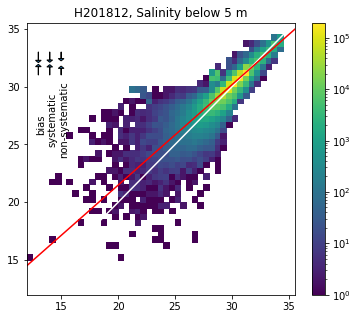

In [19]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
#d201812 = plot_and_stats(filter_bad_data(temp1), 'H201812')
d201812 = plot_and_stats(temp1, 'H201812')
d201812.style.format(myformat)

In [13]:
pieces = (
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20160101_20161231.csv',
  #       '/home/sallen/202007/H201905/ObsModel_H201905_ctd_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20150101_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20160101_20161231.csv',
  #        '/home/sallen/202007/H201905/ObsModel_H201905_psfts_20170101_20171231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20150101_20151231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20160101_20161231.csv',
  #        '/home/sallen/202007/H201905/ObsModel_H201905_pugts_20170101_20171231.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150101_20150331.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150301_20150630.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150601_20150930.csv',
          '/home/sallen/202007/H201905/ObsModel_H201905_onc_20150901_20151231.csv',
         '/home/sallen/202007/H201905/ObsModel_H201905_onc_20160101_20161231.csv',
  #        '/home/sallen/202007/H201905/ObsModel_H201905_onc_20170101_20171231.csv'
         )

/ocean/sallen/miniconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,number,bias,rmse,swillmott,slopedev,const,systematic,nonsystematic,spread
H201905,909943,0.088,0.39,0.036,0.07,2.2,0.11,0.38,0.0046


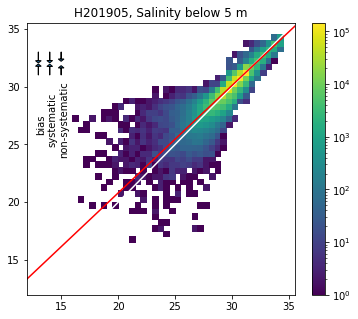

In [14]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
#d201905 = plot_and_stats(filter_bad_data(temp1), 'H201905')
d201905 = plot_and_stats(temp1, 'H201905')
d201905.style.format(myformat)

## 2017 only

ValueError: minvalue must be positive

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f94dbcb71f0> (for post_execute):


ValueError: minvalue must be positive

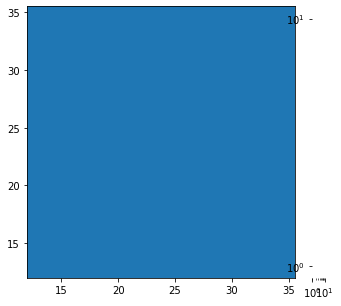

In [15]:
ntemp = filter_bad_data(temp1)
ntemp.set_index('dtUTC', inplace=True)
ntemp.sort_index(inplace=True)
ntemp.index = pd.to_datetime(ntemp.index)
d201812 = plot_and_stats(ntemp[ntemp.index > dt.datetime(2017, 1, 1)], 'H201812')
d201812.style.format(myformat)

In [ ]:
ntemp = filter_bad_data(temp1)
ntemp.set_index('dtUTC', inplace=True)
ntemp.sort_index(inplace=True)
ntemp.index = pd.to_datetime(ntemp.index)
d201905 = plot_and_stats(ntemp[ntemp.index > dt.datetime(2017, 1, 1)], 'H201905')
d201905.style.format(myformat)

## SSH difference North to West ##
Change in along strait pressure is the major difference between 201812 and 201905.  We have gone back to 201812 (9.8 cm).
Analysis over the whole time period shows 201905 is better but the initial conditions for these runs is not the same.
If we look just at 2017, after the initial conditions have had time to disappear (201812 was started in 2015), we see drift to higher salinity bias but this drift is less in 201812, slightly supporting the higher pressure difference.

### Back to All Years

In [ ]:
pieces = ('/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20150101-20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20160101-20161231.csv',
  #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170101-20170331.csv',
  #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170401-20170630.csv',
  #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20170701-20170930.csv',
  #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TS_20171001-20171231.csv',
  #       '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_TSPUG_20170101-20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20150101_20151231.csv',
        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20160101_20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_onc_20170101_20171231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20160101_20161231.csv',
 #        '/home/sallen/202007/202007C-p2/ObsModel_202007Cp2_psfts_20170101_20171231.csv'
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
dCp2 = plot_and_stats(filter_bad_data(temp1), 'Cp2')
dCp2.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150101-20150331.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150401-20150630.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20150701-20150930.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_TS_20151001-20151231.csv',
         '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_ctd_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_pugts_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_onc_20170101_20171231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007D-again/ObsModel_202007D-again_psfts_20170101_20171231.csv'
        )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
Dagain = plot_and_stats(filter_bad_data(temp1), 'Dagain')
Dagain.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_ctd_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_psfts_20170101_20171231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20150101_20151231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20160101_20161231.csv',
        '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-nociliates/ObsModel_202007D-nociliates_onc_20170101_20171231.csv'
        )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DnoC = plot_and_stats(filter_bad_data(temp1), 'D-noCil')
DnoC.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007D-lowR/ObsModel_202007D-lowR_onc_20170101_20171231.csv'
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
DlowR = plot_and_stats(filter_bad_data(temp1), 'D-lowR')
DlowR.style.format(myformat)

In [ ]:
pieces = (
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20160101_20161231.csv',
#          '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_ctd_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_TSPUG_20150101-20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20160101_20161231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_pugts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20160101_20161231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_psfts_20170101_20171231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20150101_20151231.csv',
         '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20160101_20161231.csv',
 #        '/home//sallen/202007/202007C-p3/ObsModel_202007Cp3_onc_20170101_20171231.csv'
)

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modCp3 = plot_and_stats(filter_bad_data(temp1), 'Cp3')
modCp3.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20170101_20171231.csv'
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(filter_bad_data(temp1), 'F')
modF.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20160101_20161231.csv',
     '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20160101_20161231.csv',
#          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_ctd_20170101_20171231.csv',
#       '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_onc_20170101_20171231.csv',
#          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_psfts_20170101_20171231.csv',
#          '/home/sallen/202007/202007G-p1/ObsModel_202007Gp1_pugts_20170101_20171231.csv',
          
         )

In [ ]:
temp2 = read_pieces(pieces)
temp2['SA'] = temp2.SA.fillna(value=temp2['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp2.drop(columns='Unnamed: 0', inplace=True)
temp2.drop_duplicates(inplace=True)
modGp1 = plot_and_stats(filter_bad_data(temp2), 'Gp1')
modGp1.style.format(myformat)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
vmax = 36
vmin = 12
counts, xedges, yedges, color = axs[0].hist2d(temp1.SA[temp1.k >= 5], temp1.mod_vosaline[temp1.k >= 5], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
counts2, xedges, yedges, color = axs[1].hist2d(temp2.SA[temp2.k >= 5], temp2.mod_vosaline[temp2.k >= 5], 
                                           bins=np.arange(vmin, vmax, 0.5), norm=LogNorm());
color = axs[2].pcolormesh((counts2 - counts), cmap='bwr', vmax=5, vmin=-5)
#axs[2].hist2d(temp1.SA[temp1.k >=5], temp1.mod_vosaline[temp1.k >=5] - temp2.mod_vosaline[temp2.k >=5])
fig.colorbar(color, ax=axs[2]);

In [ ]:
pieces = ('/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20160101_20161231.csv',
     '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20160101_20161231.csv',
#          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_ctd_20170101_20171231.csv',
#       '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_onc_20170101_20171231.csv',
#          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_psfts_20170101_20171231.csv',
#          '/home/sallen/202007/202007G-p2/ObsModel_202007Gp2f0_pugts_20170101_20171231.csv',
          
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modGp2 = plot_and_stats(filter_bad_data(temp1), 'Gp2')
modGp2.style.format(myformat)

In [ ]:
pieces = ('/home/sallen/202007/202007H/ObsModel_202007H_ctd_20150101_20151231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20150101_20151231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_pugts_20150101_20151231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_onc_20150101_20151231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_ctd_20160101_20161231.csv',
     '/home/sallen/202007/202007H/ObsModel_202007H_onc_20160101_20161231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20160101_20161231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_pugts_20160101_20161231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_ctd_20170101_20171231.csv',
       '/home/sallen/202007/202007H/ObsModel_202007H_onc_20170101_20171231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_psfts_20170101_20171231.csv',
          '/home/sallen/202007/202007H/ObsModel_202007H_pugts_20170101_20171231.csv',
          
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modH = plot_and_stats(filter_bad_data(temp1), 'H')
modH.style.format(myformat)

In [ ]:
pieces = ('/data/sallen/results/MEOPAR/202111/ObsModel_202111_ctd_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psfts_20150101_20151231.csv',
         '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pugts_20150101_20151231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel_202111_onc_20150101_20151231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel_202111_ctd_20160101_20161231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel_202111_psfts_20160101_20161231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel_202111_pugts_20160101_20161231.csv',
          '/data/sallen/results/MEOPAR/202111/ObsModel_202111_onc_20160101_20161231.csv',
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modv202111 = plot_and_stats(filter_bad_data(temp1), 'v202111')
modv202111.style.format(myformat)

In [ ]:
def highlight_max_min(s):
    '''
    highlight the minimum/maximum in a Series.
    '''
    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [ ]:
alltogether = pd.concat([d201812,d201905,dCp2, 
                         #Dagain, DnoC, DlowR, 
                         modCp3, #modF, modH, 
                         modGp1, modGp2,
                        modv202111], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

F is best, more important than the change in biology compared to Cp3, it is run continuously through the years and started in Nov 2014.   
New bathymetry is even better in pretty much every way. However, the new waves are not as good.  Increase the bias slightly.  At the same point, the difference is .01!

## Below this line: all is original before removing bad data

In [ ]:
alltogether = pd.concat([d201812,d201905, dCp2, Dagain, DnoC, DlowR, modF], axis=0)
foramt = "{:.2}"
alltogether.style.format(myformat).apply(highlight_max_min)

## The Hook ##

Note the hook at obs=22, model=30 : what is this?

In [ ]:
temp1.keys()

In [ ]:
plt.plot(temp1.Lon[(temp1.SA < 25) & (temp1.mod_vosaline >27)],
         temp1.Lat[(temp1.SA < 25) & (temp1.mod_vosaline >27)], 'ro');

In [ ]:
plt.plot(temp1.Lon[(temp1.SA < 25) & (temp1.mod_vosaline >27)],
         -temp1.Z[(temp1.SA < 25) & (temp1.mod_vosaline >27)], 'ro');

In [ ]:
print (temp1[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)])

In [ ]:
plt.plot(temp1.SA[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)],
 -temp1.Z[(temp1.SA < 25) & (temp1.mod_vosaline > 27) & (temp1.Z > 20)])

In [ ]:
plt.plot(temp1.SA[temp1.Lat < 47.30], 
 -temp1.Z[temp1.Lat < 47.30], 'o')

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
grid = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.set_ylim(47, 47.5)
#ax.legend()
ax.set_xlim(-123.3, -122.2);

ax.plot(temp1.Lon[temp1.Lat < 47.30], 
 temp1.Lat[temp1.Lat < 47.30], 'o');

ax.plot(-122.450123, 47.290377,'r+');

In [ ]:
plt.plot(temp1.SA[(temp1.Lat < 47.30) & (temp1.Lon > -122.5)], 
 -temp1.Z[(temp1.Lat < 47.30) & (temp1.Lon > -122.5)], 'o')
plt.ylim(-20, 0)

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
modF = plot_and_stats(temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26)], 'F')
modF.style.format(myformat)

## The Hook

Is due to a single bad profile in Tacoma Harbor.  Removing it, removes the hook and decreases the rmse, the sWillmott, the slopedev, the const, the systematic and non-systematic error and the spread deviation.

## The Box

In [ ]:
modF = plot_and_stats(temp1[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'F')
modF.style.format(myformat)

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
grid = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 temp1.Lat[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o');


In [ ]:
plt.plot(temp1.SA[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1.Z[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o')
plt.plot(temp1.mod_vosaline[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1.Z[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'g+')
plt.plot(temp1.SA[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'o')
plt.plot(temp1.mod_vosaline[(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 30.5) & (temp1.SA < 29)], 'g+')

In [ ]:
plt.plot(temp1.SA[temp1['depth (m)'] == 107])

According to ONC, all 2017 (that lower data) failed QC.

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
modF = plot_and_stats(temp1_nobox_nohook, 'F')
modF.style.format(myformat)

In [ ]:
## Without Puget Sound

In [ ]:
pieces = ('/home/sallen/202007/202007F/ObsModel_202007F_ctd_20150101_20151231.csv',
        # '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20160101_20161231.csv',
       #  '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_ctd_20170101_20171231.csv',
       #  '/home/sallen/202007/202007F/ObsModel_202007F_pugts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_psfts_20170101_20171231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20150101_20151231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20160101_20161231.csv',
         '/home/sallen/202007/202007F/ObsModel_202007F_onc_20170101_20171231.csv'
         )

In [ ]:
temp1 = read_pieces(pieces)
temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
#temp1['SA'] = temp1['salinity (g/kg)']
temp1.drop(columns='Unnamed: 0', inplace=True)
temp1.drop_duplicates(inplace=True)
temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
temp1_nobox_nohook = temp1_nohook[(temp1['depth (m)'] != 107) | (temp1.SA > 29)]
modF = plot_and_stats(temp1_nobox_nohook, 'F')
modF.style.format(myformat)

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >= 5)], 
 temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >= 5)], 'o');


In [ ]:
plt.plot(temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline > 25) & (temp1.SA < 23)& (temp1.k >=5)], 'o');
plt.plot(temp1.Lat[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 'o');

This region of the distribution is reflecting too high salinity in the model in the halocline of the SoG.

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')

ax.plot(temp1.Lon[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >= 5)], 
 temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >= 5)], 'o');

In [ ]:
plt.plot(temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline < 23) & (temp1.SA > 25)& (temp1.k >=5)], 'o');
plt.plot(temp1.Lat[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 'o');

More limited cases when the model is too fresh compared to the obs.  Note that this most often occurs on the west side, whereas the high salinities are on the east side.

In [ ]:
temp1['dtUTC'] = pd.to_datetime(temp1.dtUTC)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(temp1.dtUTC[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline < 23) & (temp1.SA > 25)& (temp1.k >=5)], 'o');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline < 23) & (temp1.SA > 25) & (temp1.k >=5)], 'o');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1.Z[(temp1.mod_vosaline > 25) & (temp1.SA < 23)& (temp1.k >=5)], 'r+');
ax.plot(temp1.dtUTC[(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 
 -temp1['depth (m)'][(temp1.mod_vosaline > 25) & (temp1.SA < 23) & (temp1.k >=5)], 'r+');
ax.tick_params(labelrotation=90)

In [ ]:
temp2017 = temp1[temp1.dtUTC > dt.datetime(2017, 1, 1)]

In [ ]:
fig, ax = plt.subplots(figsize = (6,6))
viz_tools.set_aspect(ax, coords = 'map')
viz_tools.plot_coastline(ax, grid, coords = 'map')
ax.plot(temp2017.Lon[(temp2017.mod_vosaline < 23) & (temp2017.SA > 25) & (temp2017.k >=5)], 
 temp2017.Lat[(temp2017.mod_vosaline < 23) & (temp2017.SA > 25)& (temp2017.k >=5)], 'bo');
ax.plot(temp2017.Lon[(temp2017.mod_vosaline > 25) & (temp2017.SA < 23) & (temp2017.k >=5)], 
 temp2017.Lat[(temp2017.mod_vosaline > 25) & (temp2017.SA < 23)& (temp2017.k >=5)], 'r+');

Looking just at 2017 case, it is clear that the east side is too salt in the model and the west side is too fresh.  Suggesting that the cross-strait tilt of the isohalines is not strong enough.